### Process dataset simple 

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from modular import utils 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from tqdm.auto import tqdm

from pathlib import Path
data_path = Path('data/')
image_path = data_path / '16kColorMulti'
train_dir = image_path / "train"
test_dir = image_path / "test"
image_dir = image_path / 'image'
from datasets import load_dataset, Image, load_from_disk

if(image_path.is_dir() and train_dir.is_dir() and test_dir.is_dir()):
    print(f'Target directories already exist.')
else:
    image_path.mkdir(parents=True, exist_ok=True)
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    image_dir.mkdir(parents=True, exist_ok=True)
# Setup train and testing paths

dataset = load_from_disk(image_path / 'vg.h5')
attribute_list = utils.load_json('f_attribute.json')


Target directories already exist.


In [2]:
def convert_list_to_dict(attribute_list):
    attribute_dict = {}
    for image_data in attribute_list:
        image_id=image_data['image_id']
        attributes = [x for x in image_data['attributes']]
        
        if attributes:
            attribute_dict.setdefault(image_id, [])
            attribute_dict[image_id].append({'attribute': attributes, 'bbox': image_data['bbox']})
    return attribute_dict

attribute_dict = convert_list_to_dict(attribute_list)


In [9]:
whitelisted_attributes ={'white', 'black', 'green', 'blue', 'brown', 'gray', 'yellow', 'silver', 'red', 'dark', 'cream colored', 'pink', 'blond', 'orange', 'colorful', 'purple', 'maroon', 'golden', 'chrome', 'colorless', 'rounded', 'rectangular', 'arch shaped', 'lined', 'square', 'circular', 'cylindrical', 'patterned', 'striped', 'brick', 'grassy', 'fluffy', 'soft', 'pointy', 'tiled', 'floral', 'mesh', 'dotted', 'checkered', 'bushy', 'wooden', 'plastic', 'steel', 'glass', 'stone', 'concrete', 'asphalt', 'leather', 'paper', 'rubber', 'fabric', 'ceramic', 'cardboard', 'clay', 'modern', 'shiny', 'reflective', 'transparent', 'cluttered', 'bright', 'wet', 'stacked', 'folded', 'curved', 'framed', 'cushioned', 'digital', 'black lettered', 'barren', 'filled'}
len(whitelisted_attributes)

70

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def process_dataset(n:int, dataset, attribute_dict):
    X = []
    image_dict = {}
    for data in tqdm(dataset):
        if data['image'].mode != 'RGB':
            continue
        image_id = str(data['image_id'])
        if image_id in attribute_dict.keys():
            for item in attribute_dict[image_id]:
    
                attribute = [x for x in item['attribute'] if x in whitelisted_attributes]
                if not attribute:
                    continue
    
                X.append({'image_id': image_id, 'bbox': item['bbox'], 'attribute': attribute})
                image_dict[image_id] = data['image']
            data['image'].save(image_dir/f"{data['image_id']}.jpg")
    return X, image_dict

def check_intercept(target_list: list, true_list: list, display:bool = False) -> bool:
    differences = set(target_list).intersection(set(true_list))
    if display:
        print(differences)
    return bool(differences) 

def show_example_img(dataset, name: str):
    filtered = [x for x in dataset if name in x['attribute']]
    # plt.imshow(filtered[0]['image'])
    return filtered

def top_n_labels(dataset, n: int=20):
    y = [x['attribute'] for x in dataset]
    mlb = MultiLabelBinarizer()
    fitted = mlb.fit(y)
    classes = mlb.classes_
    y_t = np.array(mlb.transform(y))
    print(y_t)
    total_sum = y_t.sum(axis=0) 
    
    label_order = {classes[x]:total_sum[x] for x in np.argsort(-total_sum)}
    X = list(label_order.keys())[:n]
    y = list(label_order.values())[:n]
    plt.figure(figsize=(20,17))
    plt.barh(X, y)
    return X,y

def calculate_attribute_occurences(dict_list : list):
    mlb = MultiLabelBinarizer()
    attribute_list = [x['attribute'] for x in dict_list]
    attribute_arr = np.array(mlb.fit_transform(attribute_list))
    classes = mlb.classes_
    occurences_arr = attribute_arr.sum(axis=0)
    sorted_occurences_dict = {classes[x]:occurences_arr[x] for x in np.argsort(-occurences_arr)}
    return sorted_occurences_dict

def plot_hbar(sorted_occurences_dict: dict):
    plt.figure(figsize=(20,17))
    X = list(sorted_occurences_dict.keys())
    y = list(sorted_occurences_dict.values())
    if(len(X) > 100):
        print('Attributes shown is set to top 100 for viewing purpose')
        X = X[:100]
        y = y[:100]
    plt.barh(X, y)
   

def undersampling_data(dict_list : list, threshold:int = 100):
    mlb = MultiLabelBinarizer()
    attribute_list = [x['attribute'] for x in dict_list]
    attribute_arr = np.array(mlb.fit_transform(attribute_list))
    
    attribute_idx = np.array((range(0, len(attribute_list))))

    sum_arr = attribute_arr.sum(axis=0)
    thres_idx = np.where(sum_arr > threshold)
    
    mask = np.all(attribute_arr[:,thres_idx] > 0, axis=1)   
    mask = np.logical_or.reduce(mask, axis=1) 
    strict_1 = attribute_arr.sum(axis=1) == 1 & mask

    over_threshold = attribute_arr[strict_1]
    under_threshold = attribute_arr[~strict_1]
    over_idx = attribute_idx[strict_1]
    under_idx = attribute_idx[~strict_1]

    for idx in thres_idx[0]:
    
        idx_mask = over_threshold[:,idx] == 1
        over_arr = over_threshold[idx_mask]
        current_idx = over_idx[idx_mask]

        counter = under_threshold[under_threshold[:, idx] == 1].shape[0]
        if counter < threshold:
            diff = threshold - counter
            random = np.random.choice(over_arr.shape[0], size=diff, replace=False)
            samples = over_arr[random]
            sample_idx = current_idx[random]

            under_idx = np.append(under_idx, sample_idx)
            under_threshold = np.vstack((under_threshold, samples))
       

    return under_idx

    



In [10]:
X, image_dict = process_dataset(50000, dataset=dataset, attribute_dict=attribute_dict)

  0%|          | 0/102073 [00:00<?, ?it/s]

In [11]:
orig = calculate_attribute_occurences(dict_list=X)
u = undersampling_data(X, threshold=1000)
sampled_dict = [X[x] for x in u]
u_graph = calculate_attribute_occurences(dict_list=sampled_dict)



63
[17, 35, 2, 59, 54]


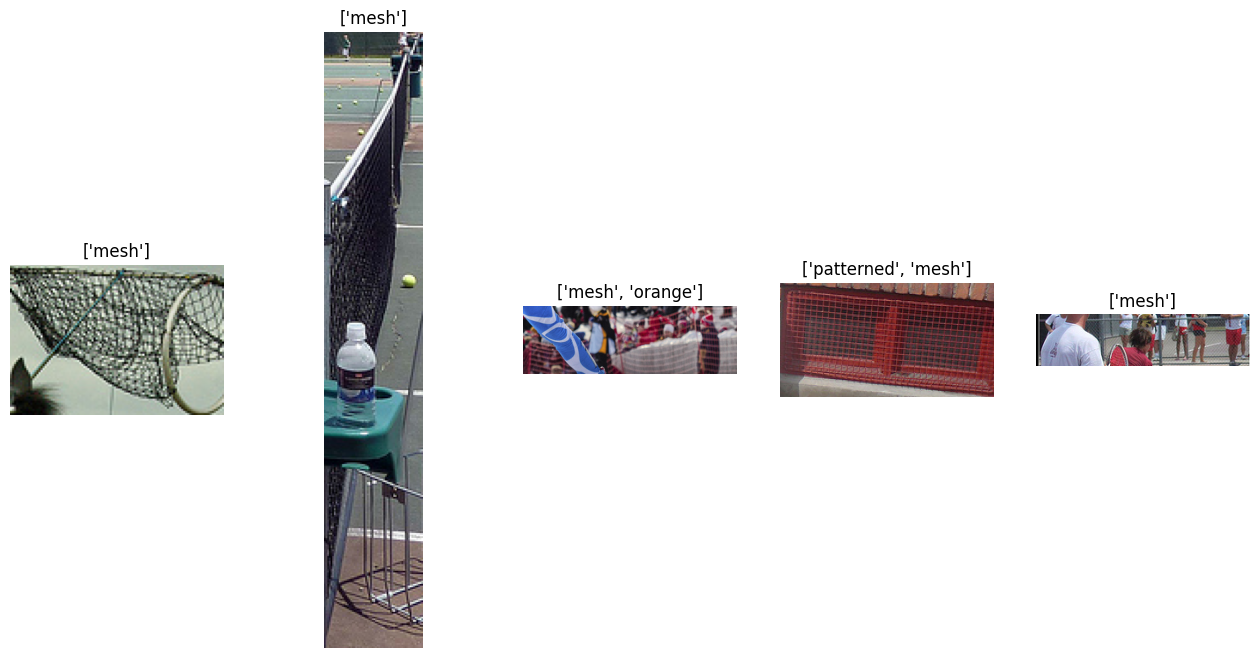

In [14]:
from modular import utils, data_setup
import random

def show_image_samples(dict_list, image_dict, attribute:str, n:int = 5):
    f_set = [x for x in dict_list if check_intercept(target_list=x['attribute'], true_list=[attribute])]
    print(len(f_set))
    random_samples_idx = random.sample(range(len(f_set)), k=n)
    print(random_samples_idx)
    plt.figure(figsize=(16,8))


    for i, idx in enumerate(random_samples_idx):

        targ_image, targ_label = image_dict[f_set[idx]['image_id']], f_set[idx]['attribute']
       
        targ_image_adjust = utils.crop_img(image=targ_image, bbox=f_set[idx]['bbox'])
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.title(targ_label)
        plt.axis(False)

show_image_samples(dict_list=X, image_dict=image_dict, attribute='mesh')
# u_graph, plot_hbar(u_graph)

(['white',
  'black',
  'brown',
  'rounded',
  'red',
  'blue',
  'wooden',
  'green',
  'gray',
  'dark',
  'shiny',
  'patterned',
  'yellow',
  'silver',
  'rectangular',
  'plastic',
  'pink',
  'orange',
  'square',
  'striped',
  'curved',
  'glass',
  'concrete',
  'colorful',
  'brick',
  'bright',
  'wet',
  'purple',
  'stone',
  'grassy',
  'tiled',
  'circular',
  'steel',
  'blond',
  'pointy',
  'cream colored',
  'golden',
  'fluffy',
  'stacked',
  'reflective',
  'folded',
  'leather',
  'ceramic',
  'paper',
  'lined',
  'framed',
  'soft',
  'modern',
  'transparent',
  'chrome',
  'floral',
  'asphalt',
  'arch shaped',
  'maroon',
  'rubber',
  'cluttered',
  'checkered',
  'digital',
  'black lettered',
  'cardboard',
  'clay',
  'cushioned',
  'filled',
  'bushy',
  'colorless',
  'cylindrical',
  'fabric',
  'mesh',
  'barren',
  'dotted'],
 32701,
 None)

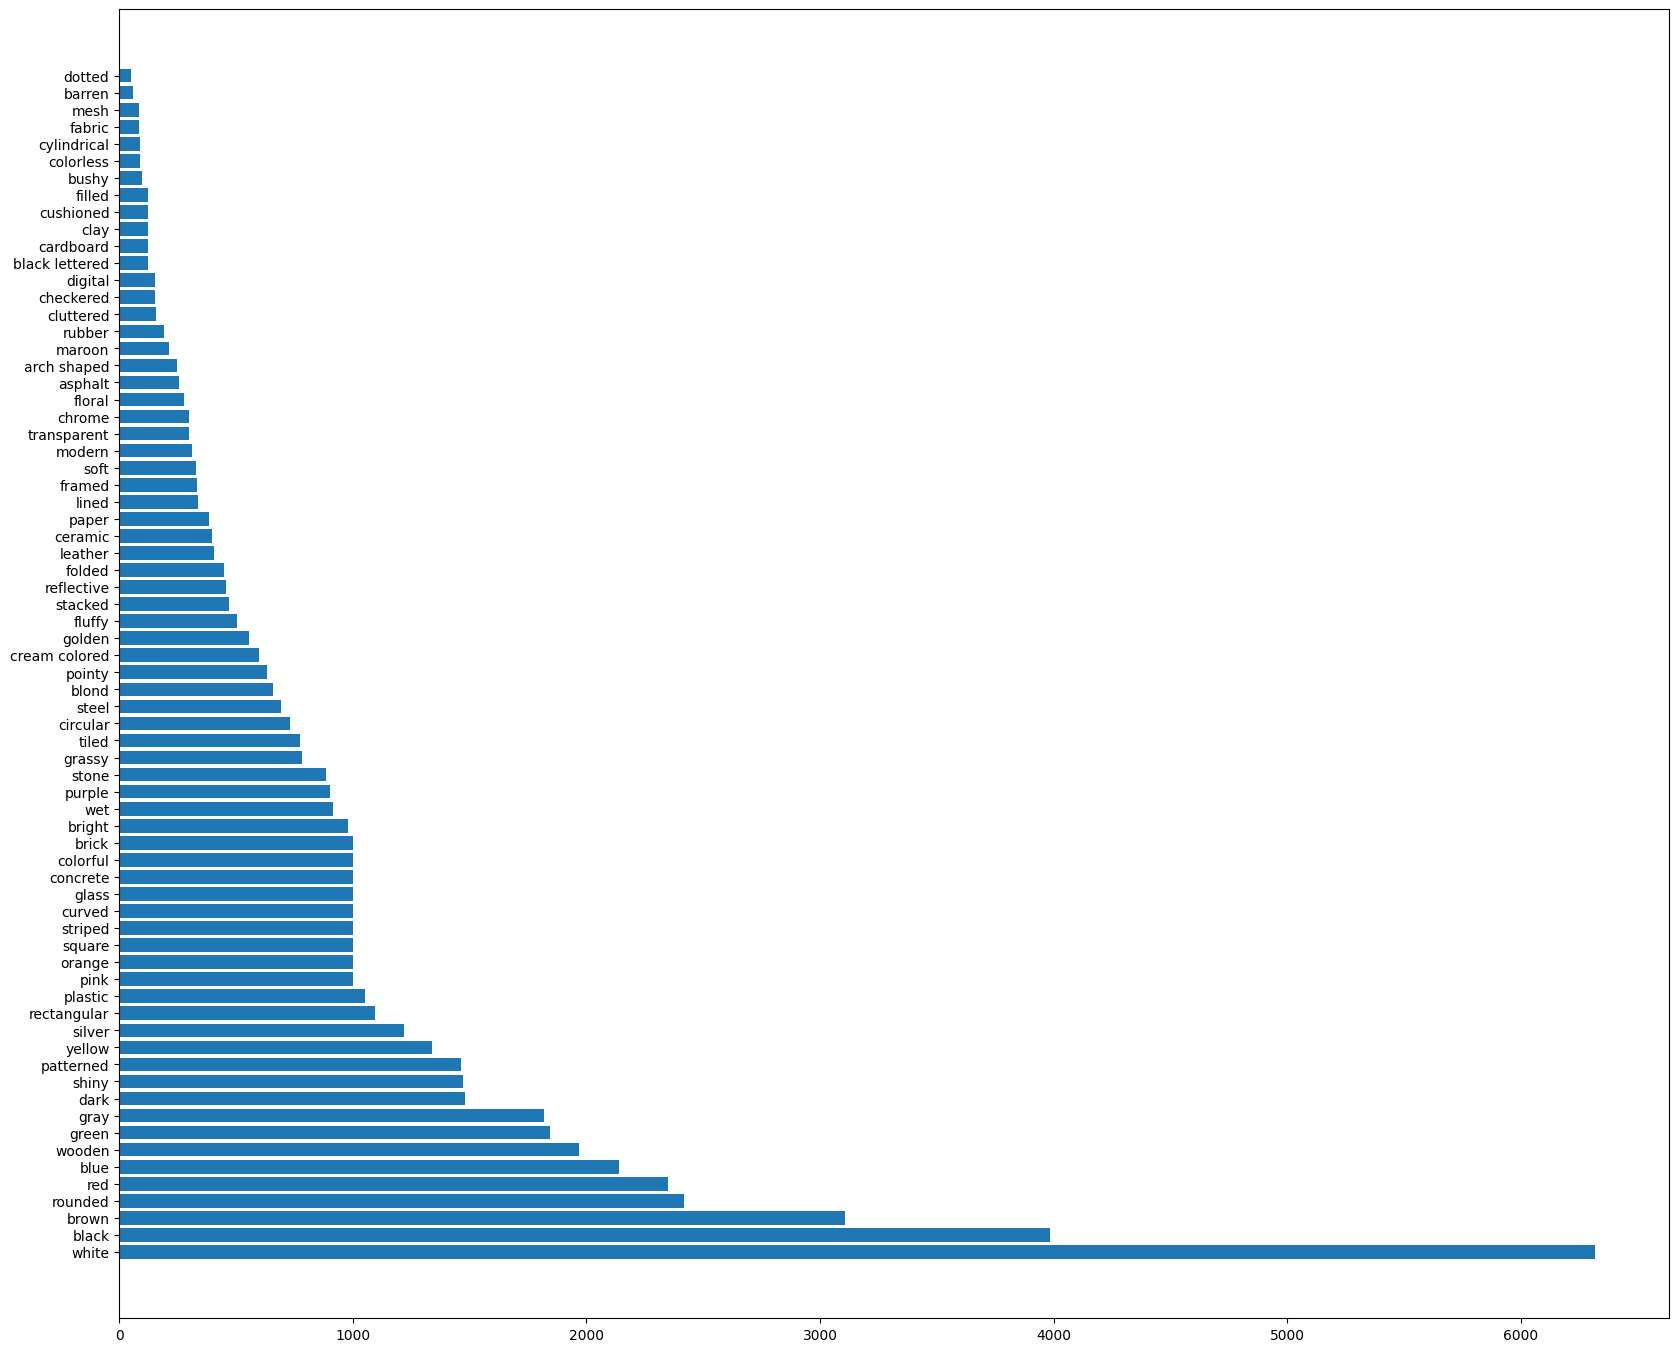

In [14]:
classes = [x for x in u_graph.keys()]
classes, len(sampled_dict), plot_hbar(u_graph)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


86060

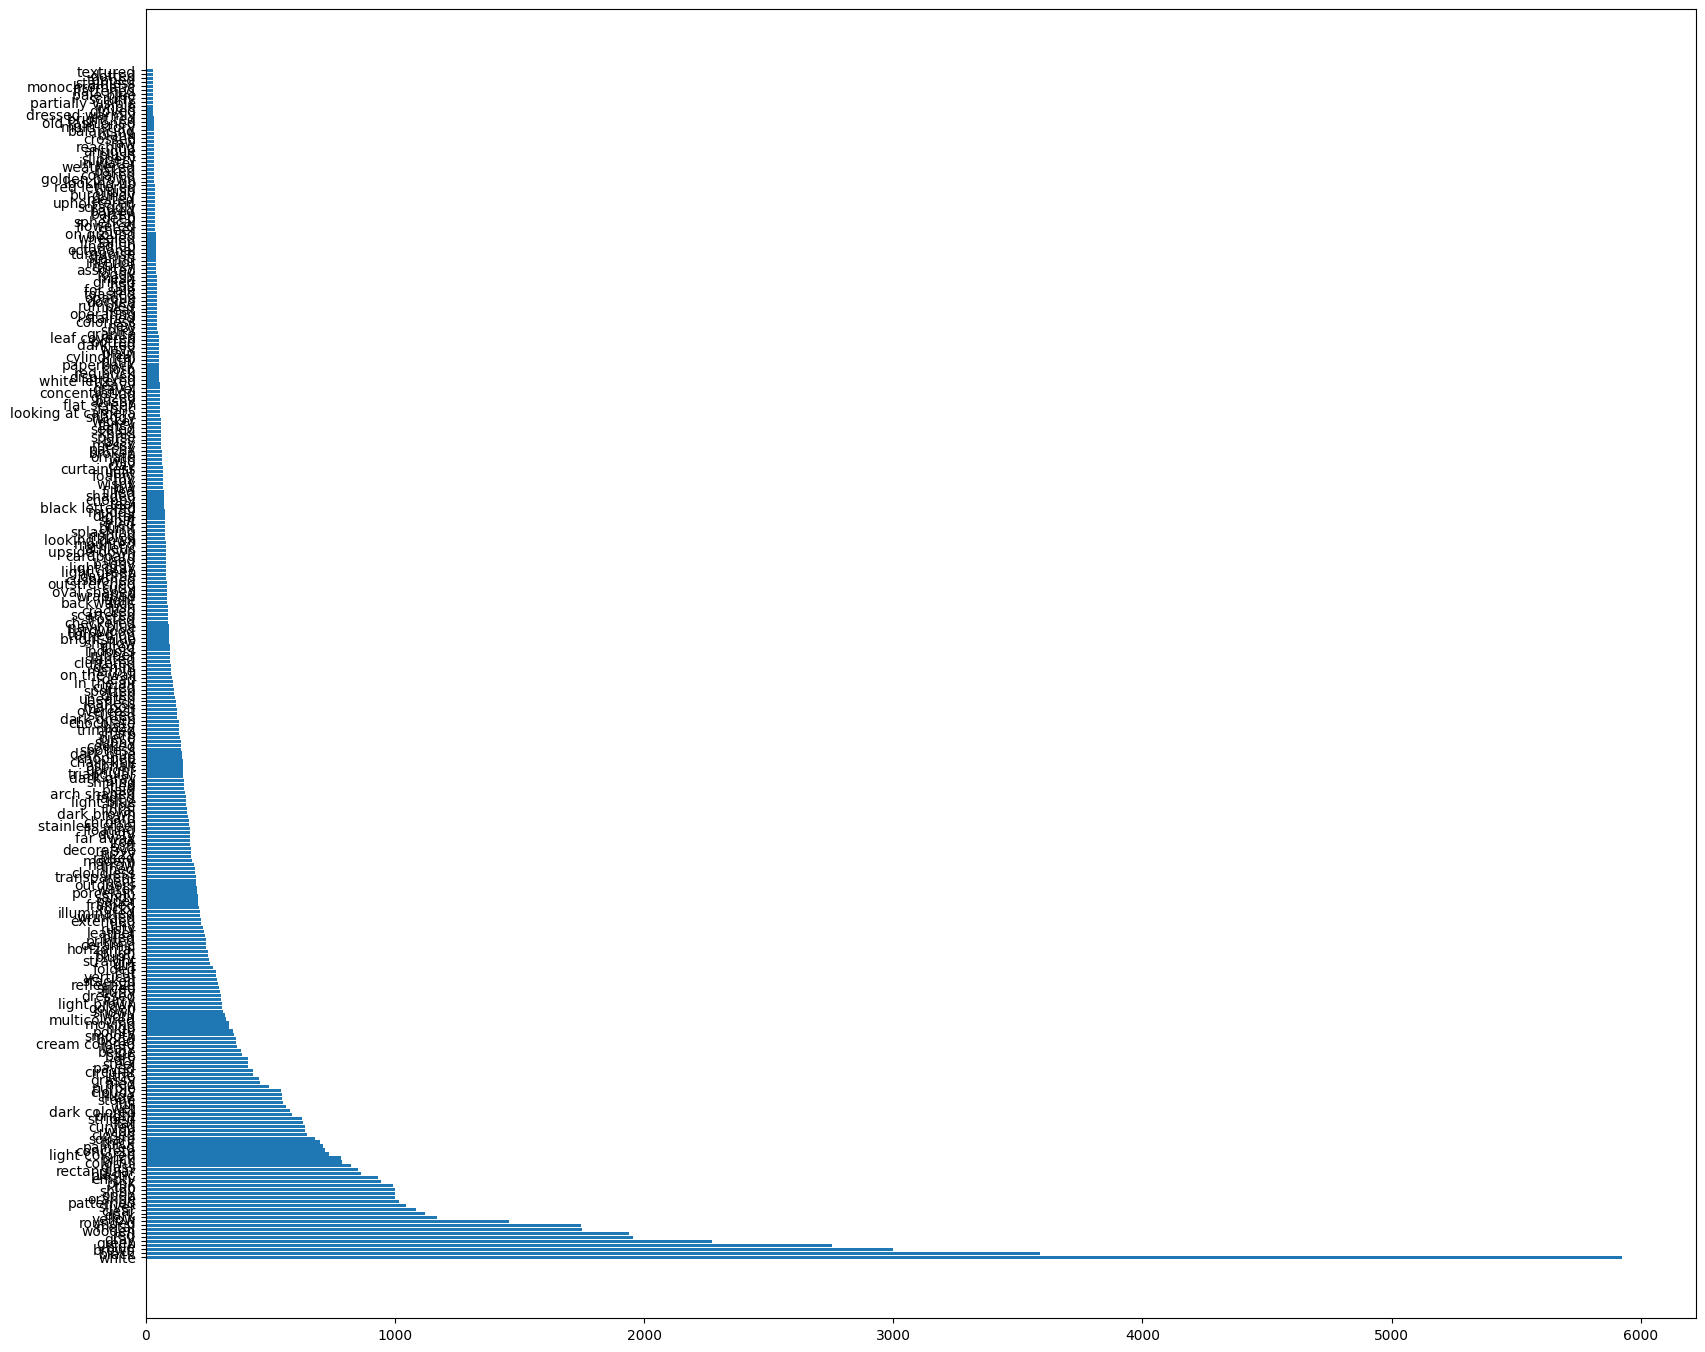

In [80]:

filtered_set, y = top_n_labels(dataset=sampled_dict, n=300)

filtered_X = [image for image in X if bool(set(image['attribute'])-set(filtered_set)) is False]

len(filtered_X)


In [13]:
import json


with open(image_path/'attribute_dict.json', 'w') as json_file:
    json.dump(sampled_dict, json_file)
with open(image_path/'attributes.json', 'w') as json_file:
    json.dump(classes, json_file)